In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [ ]:
def tf_soft_contrast(image, label):
    image = tf.cast(image, tf.float32) / 255.0

    image = tf.image.adjust_contrast(image, contrast_factor=1.5) 

    image = tf.repeat(image, 3, axis=-1)

    return image, label

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/train2",
    seed=41,
    shuffle=True,
    image_size=(256, 256),
    batch_size=None,            
    color_mode='grayscale'
)

class_names = train_ds.class_names
print("class_names: ",class_names)
print("number of classes: ", len(class_names))

train_ds = train_ds.map(tf_soft_contrast)
train_ds = train_ds.batch(32)  
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/test",
    seed=41,
    shuffle=True,
    image_size=(256, 256),
    batch_size=None,            
    color_mode='grayscale'
)

test_ds = test_ds.map(tf_soft_contrast)
test_ds = test_ds.batch(32)  
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/validate",
    seed=41,
    shuffle=True,
    image_size=(256, 256),
    batch_size=None,           
    color_mode='grayscale'
)

val_ds = test_ds.map(tf_soft_contrast)
val_ds = test_ds.batch(32)   
val_ds = test_ds.prefetch(tf.data.AUTOTUNE)



Found 5834 files belonging to 4 classes.
class_names:  ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
number of classes:  4
Found 2247 files belonging to 4 classes.
Found 2345 files belonging to 4 classes.


In [6]:
def tf_split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_set = ds.take(train_size)
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

train_ds, val_ds, test_ds = tf_split_data(tf_dataset)

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),             
    layers.RandomRotation(0.05),                  
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05),
])


In [10]:
val_ds = val_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
test_ds = test_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

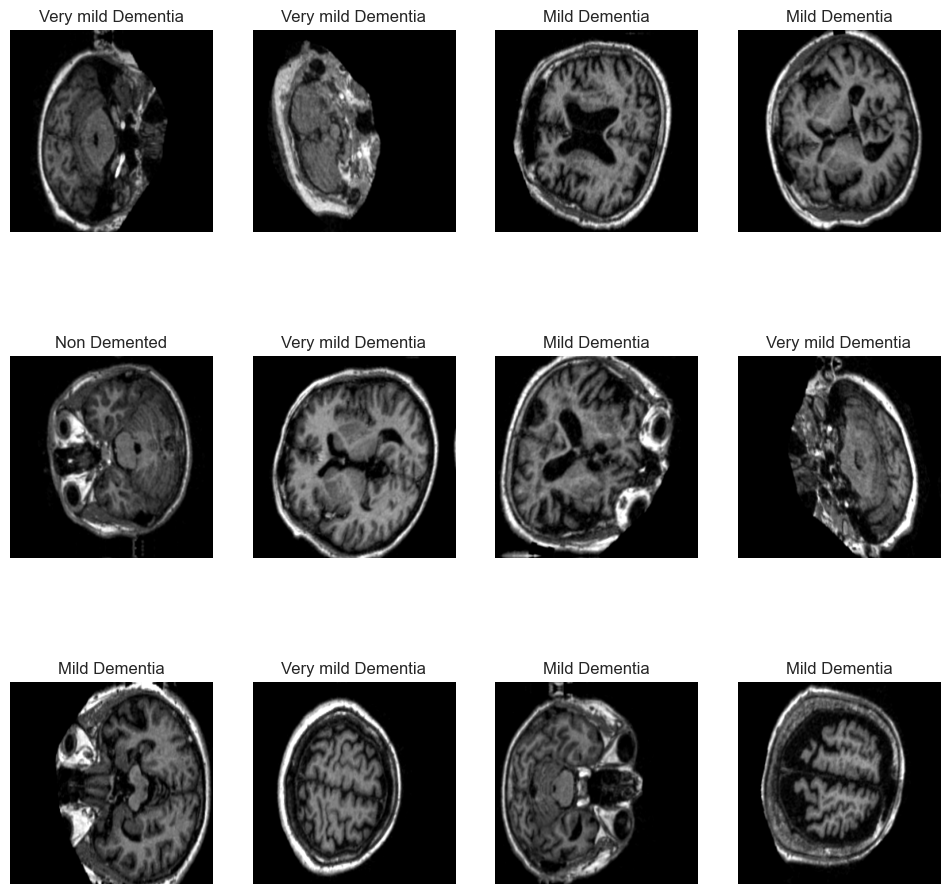

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("float32"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
input_shape = (None,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [16]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.trainable = False


In [17]:
model = models.Sequential([
    base_model, 

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 64)       │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,788,228 (33.52 MB)

 Trainable params: 1,749,828 (6.68 MB)

 Non-trainable params: 7,038,400 (26.85 MB)

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.4288 - loss: 1.4399 - val_accuracy: 0.4459 - val_loss: 1.0736 - learning_rate: 0.0010
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.6581 - loss: 0.8291 - val_accuracy: 0.5518 - val_loss: 1.3415 - learning_rate: 0.0010
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.6960 - loss: 0.7187 - val_accuracy: 0.6355 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.7446 - loss: 0.6449 - val_accuracy: 0.6578 - val_loss: 0.9567 - learning_rate: 0.0010
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.7742 - loss: 0.5929 - val_accuracy: 0.7428 - val_loss: 0.6223 - learning_rate: 0.0010
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.8119 - loss: 0.4991 - val_accuracy: 0.6004 - val_loss: 0.9141 - learning_rate: 0.0010
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8082 - loss: 0.49

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.8465 - loss: 0.3915 - val_accuracy: 0.7534 - val_loss: 0.7403 - learning_rate: 2.5000e-04
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.8603 - loss: 0.3622 - val_accuracy: 0.7388 - val_loss: 0.7805 - learning_rate: 2.5000e-04
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8729 - loss: 0.3451 - val_accuracy: 0.7828 - val_loss: 0.6624 - learning_rate: 2.5000e-04
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.8883 - loss: 0.3123 - val_accuracy: 0.7837 - val_loss: 0.6333 - learning_rate: 2.5000e-04
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.8902 - loss: 0.2951 - val_accuracy: 0.7904 - val_loss: 0.6119 - learning_rate: 2.5000e-04
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9024 - loss: 0.2557 - val_accuracy: 0.8260 - val_loss: 0.5197 - learning_rate: 2.5000e-04
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - acc

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.4467 - loss: 1.3955 - val_accuracy: 0.5051 - val_loss: 1.0109 - learning_rate: 0.0010
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.6220 - loss: 0.8628 - val_accuracy: 0.5750 - val_loss: 0.8830 - learning_rate: 0.0010
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.7029 - loss: 0.7299 - val_accuracy: 0.6903 - val_loss: 0.8110 - learning_rate: 0.0010
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.7340 - loss: 0.6587 - val_accuracy: 0.6155 - val_loss: 0.8756 - learning_rate: 0.0010
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7506 - loss: 0.6260
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
183/183 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7506 - loss: 0.6259 - val_accuracy: 0.6084 - val_loss: 1.0722 - learning_rate: 0.0010
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.7957 - loss: 0.498

In [27]:
scores = model.evaluate(test_ds)

71/71 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8278 - loss: 0.4962


In [24]:
model.save("2dCNN222augm1030.keras")

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


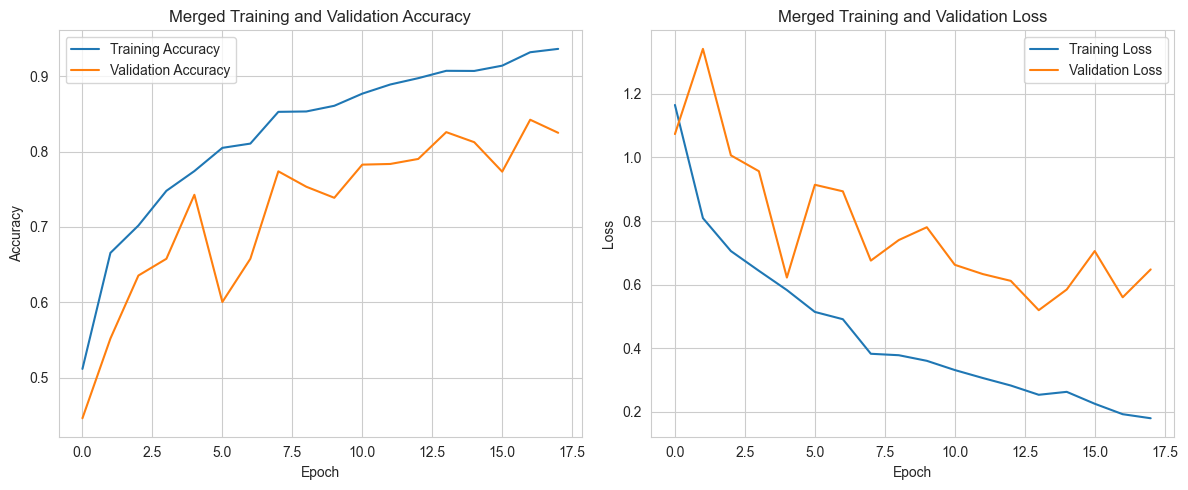

In [ ]:
def merge_histories(hist1, hist2):
    merged_history = {}

    for key in hist1.history.keys():
        merged_history[key] = hist1.history[key] + hist2.history[key]  # concatenate lists

    return merged_history

merged = merge_histories(history, history2)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(merged['accuracy'], label='Training Accuracy')
plt.plot(merged['val_accuracy'], label='Validation Accuracy')
plt.title('Merged Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(merged['loss'], label='Training Loss')
plt.plot(merged['val_loss'], label='Validation Loss')
plt.title('Merged Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


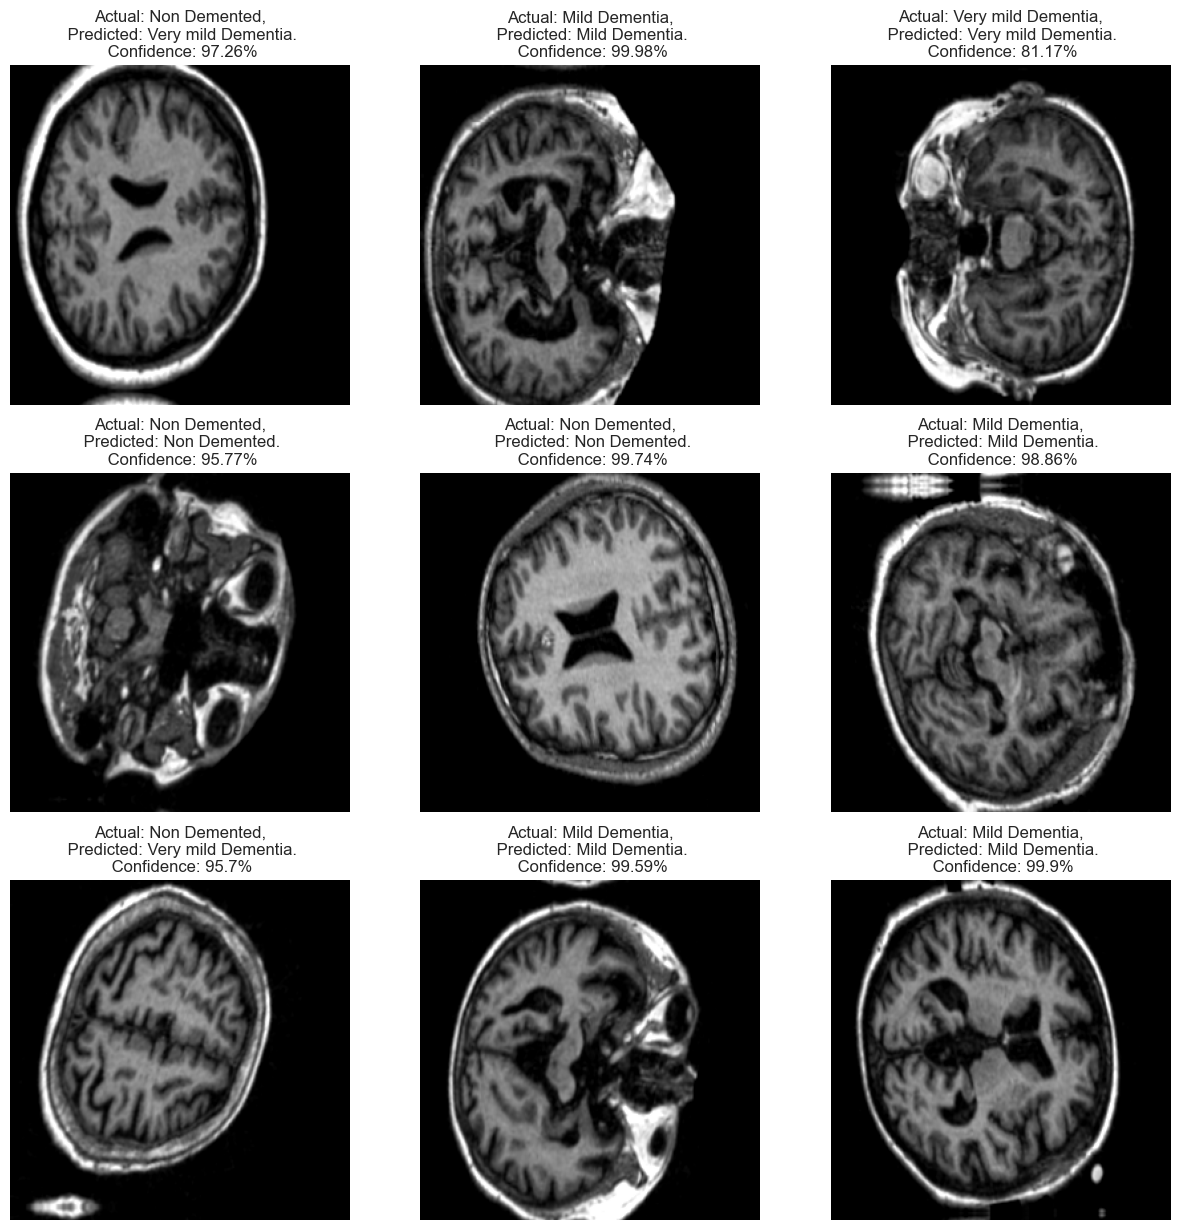

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

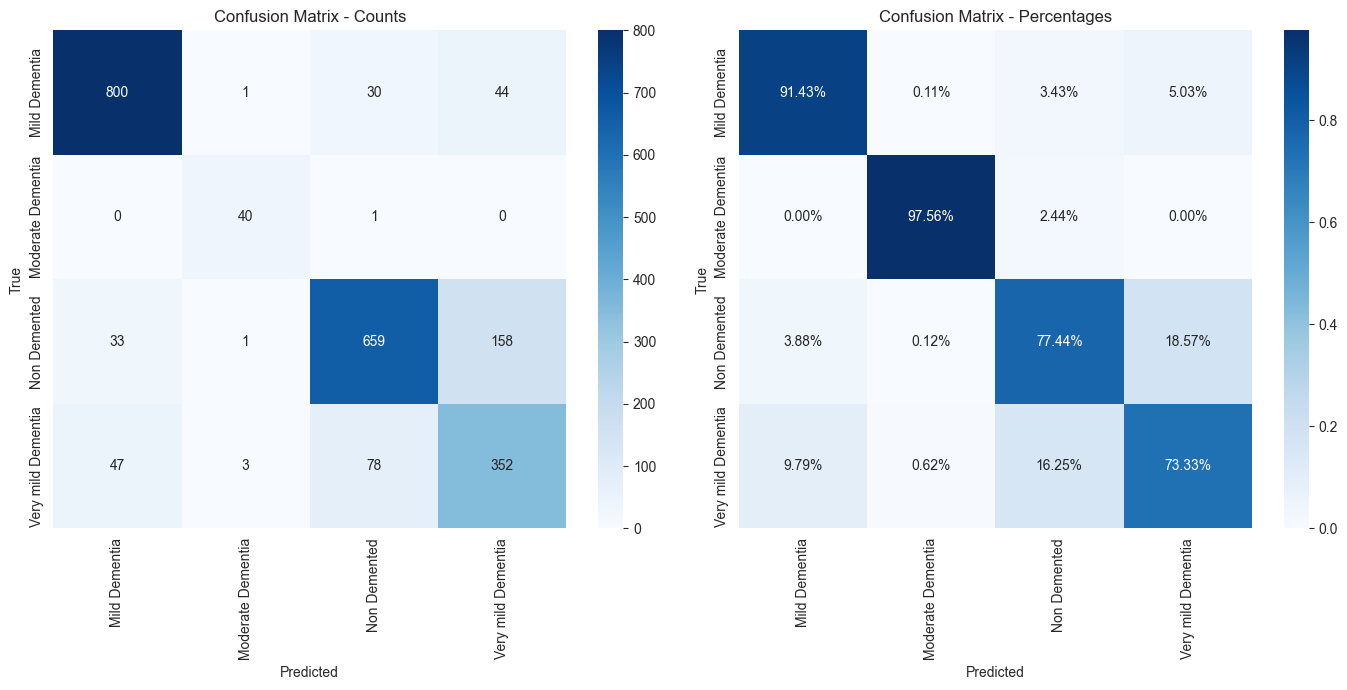

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def get_true_labels_and_predictions(model, dataset):
    true_labels = []
    predictions = []
    for batch in dataset:  
        images, labels = batch
        preds = model.predict(images)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))
    return true_labels, predictions

true_labels, predicted_labels = get_true_labels_and_predictions(model, test_ds)

cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the raw confusion matrix
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # First subplot for raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Counts')


plt.subplot(1, 2, 2) 
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Percentages')

plt.tight_layout() 
plt.show()

In [75]:
model2.save("2dCNN222augmmodel2.keras")

In [31]:
!pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-40648 (build 11.0.16.1+1-LTS, mixed mode)
  Starting server from C:\Users\casap\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\casap\AppData\Local\Temp\tmp607r3ltv
  JVM stdout: C:\Users\casap\AppData\Local\Temp\tmp607r3ltv\h2o_casap_started_from_python.out
  JVM stderr: C:\Users\casap\AppData\Local\Temp\tmp607r3ltv\h2o_casap_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Athens
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,"1 year, 2 months and 18 days"
H2O_cluster_name:,H2O_from_python_casap_rvvupf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.922 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [ ]:
from tensorflow.keras.models import Model
print(model.inputs)
feature_extractor_layer = model.layers[-8].output  
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-8].output)

def extract_features(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = feature_extractor.predict(images)
        features = features.reshape(features.shape[0], -1)  
        all_features.append(features)
        all_labels.extend(labels.numpy())
    return np.vstack(all_features), np.array(all_labels)


[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor_2256>]


In [33]:
train_features, train_labels = extract_features(train_ds)
val_features, val_labels = extract_features(val_ds)
test_features, test_labels = extract_features(test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [34]:
train_frame = h2o.H2OFrame(np.hstack((train_features, train_labels.reshape(-1, 1))),
                           column_names=[f'feature_{i}' for i in range(train_features.shape[1])] + ['label'])
val_frame = h2o.H2OFrame(np.hstack((val_features, val_labels.reshape(-1, 1))),
                         column_names=[f'feature_{i}' for i in range(val_features.shape[1])] + ['label'])
test_frame = h2o.H2OFrame(np.hstack((test_features, test_labels.reshape(-1, 1))),
                          column_names=[f'feature_{i}' for i in range(test_features.shape[1])] + ['label'])

train_frame['label'] = train_frame['label'].asfactor()
val_frame['label'] = val_frame['label'].asfactor()
test_frame['label'] = test_frame['label'].asfactor()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
automl = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)
automl.train(x=train_frame.columns[:-1], y='label', training_frame=train_frame, validation_frame=val_frame)

print(automl.leaderboard)


AutoML progress: |
14:36:58.156: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
14:36:58.179: AutoML: XGBoost is not available; skipping it.
14:36:58.306: _train param, Dropping bad and constant columns: [feature_302, feature_740, feature_28, feature_451, feature_572, feature_77, feature_46, feature_392, feature_629, feature_707, feature_828, feature_709, feature_814]

█
14:37:04.739: GLM_1_AutoML_1_20250601_143658 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: Index 1010 out of bounds for length 1010
14:37:04.770: _train param, Dropping bad and constant columns: [feature_302, feature_740, feature_28, feature_451, feature_572, feature_77, feature_46, feature_392, feature_629, feature_707, feature_828, feature_709, feature_814]

███████████████
14:39:27.216: _train

In [36]:

performance = automl.leader.model_performance(test_frame)
print(performance)


ModelMetricsMultinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.14589082622808125
RMSE: 0.3819565763644884
LogLoss: 0.609035961293353
Null degrees of freedom: 2246
Residual degrees of freedom: 2222
Null deviance: 5489.966163357613
Residual deviance: 2737.0076100523283
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    3    Error      Rate
---  ---  ---  ---  ---------  -----------
815  0    18   42   0.0685714  60 / 875
0    40   0    1    0.0243902  1 / 41
25   1    677  148  0.204465   174 / 851
49   4    85   342  0.2875     138 / 480
889  45   780  533  0.165999   373 / 2,247

Top-4 Hit Ratios: 
k   

In [37]:
predictions = automl.leader.predict(test_frame)
confusion_matrix = predictions['predict'].cbind(test_frame['label']).table()
print(confusion_matrix)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
  predict    label    Counts
        0        0       815
        0        2        25
        0        3        49
        1        1        40
        1        2         1
        1        3         4
        2        0        18
        2        2       677
        2        3        85
        3        0        42
[13 rows x 3 columns]



In [38]:
model_path = h2o.save_model(model=automl.leader, path="./", force=True)
print("Model saved to: " + model_path)

Model saved to: C:\D\Master\MasterThesis\DisertationThesis\StackedEnsemble_BestOfFamily_1_AutoML_1_20250601_143658


In [39]:
import pandas as pd

confusion_matrix_df = confusion_matrix.as_data_frame(use_pandas=True)
pivot_cm = pd.pivot_table(confusion_matrix_df, values='Counts', index='label', columns='predict', fill_value=0)

all_classes = sorted(set(pivot_cm.columns).union(set(pivot_cm.index)))
pivot_cm = pivot_cm.reindex(index=all_classes, columns=all_classes, fill_value=0)

print(pivot_cm)


C:\Users\casap\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


predict      0     1      2      3
label                             
0        815.0   0.0   18.0   42.0
1          0.0  40.0    0.0    1.0
2         25.0   1.0  677.0  148.0
3         49.0   4.0   85.0  342.0


In [40]:
import pandas as pd

confusion_matrix_df = confusion_matrix.as_data_frame(use_pandas=True)

pivot_cm = pd.pivot_table(confusion_matrix_df, values='Counts', index='label', columns='predict', fill_value=0)

all_classes = sorted(set(pivot_cm.columns).union(set(pivot_cm.index)))
pivot_cm = pivot_cm.reindex(index=all_classes, columns=all_classes, fill_value=0)


row_totals = pivot_cm.sum(axis=1)
percentage_cm = pivot_cm.div(row_totals, axis=0) * 100


print(percentage_cm)


predict          0          1          2          3
label                                              
0        93.142857   0.000000   2.057143   4.800000
1         0.000000  97.560976   0.000000   2.439024
2         2.937720   0.117509  79.553467  17.391304
3        10.208333   0.833333  17.708333  71.250000


C:\Users\casap\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


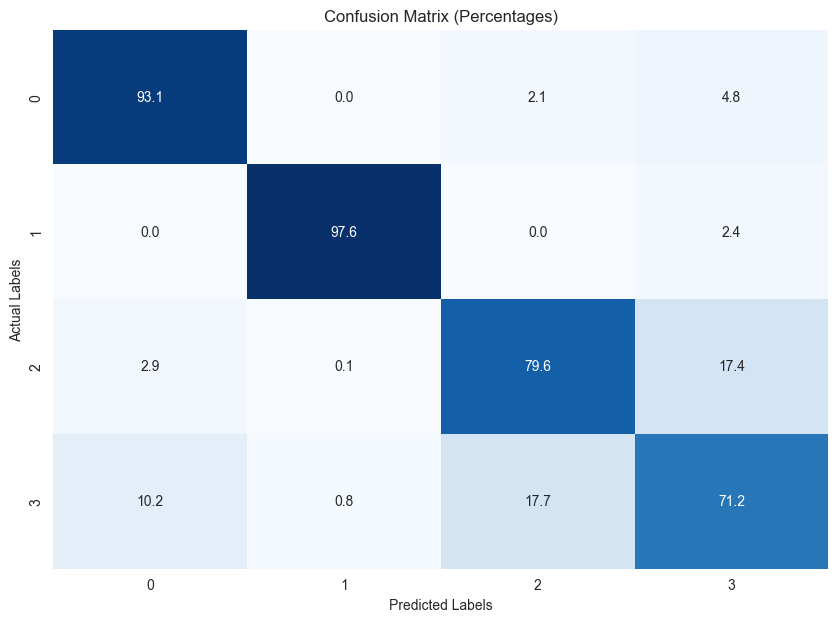

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(percentage_cm, annot=True, fmt=".1f", cmap="Blues", cbar=False) 
plt.title("Confusion Matrix (Percentages)")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [4]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
# normal data raw
loaded_model = h2o.load_model("StackedEnsemble_BestOfFamily_1_AutoML_1_20250601_143658")

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 hour 2 mins
H2O_cluster_timezone:,Europe/Athens
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,"1 year, 3 months and 12 days"
H2O_cluster_name:,H2O_from_python_casap_zoxcwv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.470 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [5]:
loaded_model.summary()  

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/4
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None
